# 프로젝트: Spectrogrm classification 모델

### 오늘 실습에서 1차원 Waveform 데이터를 입력받아 Text 라벨을 출력하는 모델을 기본 버전과 Skip-connection 버전으로 나누어 학습시켜 보았습니다. 이번에는 2차원 Spectrogram 데이터를 입력받아 위 모델과 동일한 역할을 수행하는 모델을 아래 제시된 단계와 같이 수행해 보시기 바랍니다. 이번에도 마찬가지로 기본 버전과 Skip-connection 버전으로 나누어 각각 진행해 보시기 바랍니다. 모델 구조를 제외하고는 실습에서 제시된 것과 거의 동일하게 진행될 것입니다

## 0. 데이터 불러오기 !

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


In [2]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [3]:
# 위에서 뽑았던 sample data
spec = []
for wav in speech_data["wav_vals"]:
    spec.append(wav2spec(wav))
spec = np.array(spec)

In [4]:
print("Waveform shape : ",speech_data["wav_vals"].shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (50620, 8000)
Spectrogram shape :  (50620, 130, 126)


In [5]:
## Spectrogram 으로 변환 !

In [6]:
import IPython.display as ipd ## 데이터가 맞는지 확인하기!
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr) 

rand num :  13196
Wave data shape :  (8000,)
label :  ['right']


## 1. 데이터 처리와 분류

### - 라벨 데이터 처리하기

In [7]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [8]:
temp = [] 
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

In [9]:
# Text로 이루어진 라벨 데이터를 학습에 사용하기 위해 index 형태로 변환

### - sklearn의 train_test_split함수를 이용하여 train, test 분리

In [10]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(spec, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

#train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
#test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

[[[2.0094678e-02 8.9830840e-03 1.7142865e-03 ... 2.6799546e-04
   1.9452425e-03 6.5677855e-03]
  [2.4236267e-02 1.2035743e-02 2.5152902e-03 ... 3.0103549e-03
   5.1366119e-03 6.5334761e-03]
  [3.0824188e-02 1.7855115e-02 3.4057829e-03 ... 7.7932440e-03
   3.2631224e-03 6.1808764e-03]
  ...
  [4.0481216e-03 1.7460239e-03 5.5177836e-04 ... 5.8769871e-04
   2.4102803e-03 4.4118767e-03]
  [3.9796731e-03 2.1453821e-03 7.2943541e-05 ... 1.9987840e-04
   2.5438287e-03 4.7259801e-03]
  [4.0695826e-03 2.0019137e-03 4.7747297e-05 ... 6.1459104e-05
   2.2882158e-03 4.6141762e-03]]

 [[6.1523337e-02 2.1242203e-02 2.2213278e-02 ... 7.4587807e-02
   9.6397139e-02 4.3026574e-02]
  [1.2102966e-01 7.9019725e-02 8.0798067e-02 ... 9.8431237e-02
   8.5878693e-02 2.6347847e-03]
  [1.9121540e-01 1.3377683e-01 7.5925484e-02 ... 1.7420796e-01
   1.5357125e-01 7.5176142e-02]
  ...
  [6.5018008e-03 3.0771201e-03 5.9713941e-04 ... 7.8595878e-04
   4.8435692e-04 1.0462347e-03]
  [6.0369312e-03 3.0784740e-03 6.876

In [11]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 130, 126)
train labels :  (45558,)
test data :  (5062, 130, 126)
test labels :  (5062,)
✅


## 2. 학습을 위한 하이퍼파라미터 설정

In [12]:
batch_size = 12
max_epochs = 5

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj12/aiffel/speech_recognition/models/wav'

## 3. 데이터셋 구성

### - tf.data.Dataset을 이용

### - from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용

### - map과 batch를 이용한 데이터 전처리

In [13]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [14]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
✅


### - 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다. tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.
#### del speech_data / del spec_data 데이터 or 메모리 버퍼 비우기

## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

### - 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능

### - batchnorm, dropout, dense layer 등을 이용

In [15]:
from tensorflow.keras import layers
input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D(2,2)(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D(2,2)(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D(2,2)(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D(2,2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 130, 126, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 130, 126, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 65, 63, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### - 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용

In [16]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


### - 모델 가중치를 저장하는 checkpoint callback 함수 추가

In [17]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


### - 다양한 모델의 실험을 진행해 보시기 바랍니다.

In [18]:
#30분 내외 소요
x = len(train_wav) // batch_size
del train_wav
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=x,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/5
3796/3796 [==============================] - ETA: 0s - loss: 0.7693 - accuracy: 0.7546
Epoch 00001: val_loss improved from inf to 0.30989, saving model to /home/aiffel-dj12/aiffel/speech_recognition/models/wav_skip
3796/3796 [==============================] - 86s 23ms/step - loss: 0.7693 - accuracy: 0.7546 - val_loss: 0.3099 - val_accuracy: 0.9084
Epoch 2/5
3795/3796 [============================>.] - ETA: 0s - loss: 0.2788 - accuracy: 0.9151
Epoch 00002: val_loss improved from 0.30989 to 0.17432, saving model to /home/aiffel-dj12/aiffel/speech_recognition/models/wav_skip
3796/3796 [==============================] - 84s 22ms/step - loss: 0.2787 - accuracy: 0.9151 - val_loss: 0.1743 - val_accuracy: 0.9458
Epoch 3/5
3794/3796 [============================>.] - ETA: 0s - loss: 0.1794 - accuracy: 0.9454
Epoch 00003: val_loss improved from 0.17432 to 0.13436, saving model to /home/aiffel-dj12/aiffel/speech_recognition/models/wav_skip
3796/3796 [==============================] - 88

In [19]:
del spec
del speech_data
#del train_wav 

## 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

### - loss, accuracy를 그래프로 표현

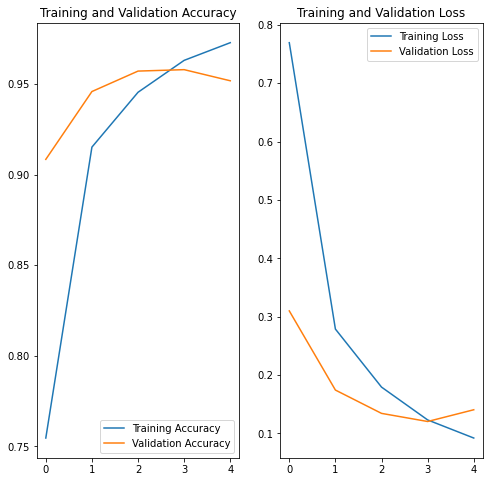

✅


In [20]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

## 6. Test dataset을 이용해서 모델의 성능을 평가

### - 저장한 weight 불러오기

In [21]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

422/422 [==============================] - 36s 84ms/step - loss: 0.1203 - accuracy: 0.9579
loss value: 0.120
accuracy value: 95.7922%
✅


### - 모델의 예측값과 정답값이 얼마나 일치하는지 확인

In [25]:
#Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)
batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)
#a= librosa.istft(batch_xs.reshape(130,126))

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(130, 126), rate=8000)
#ipd.Audio(a, rate=8000)

label :  on


In [26]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: on(Correct!)
✅


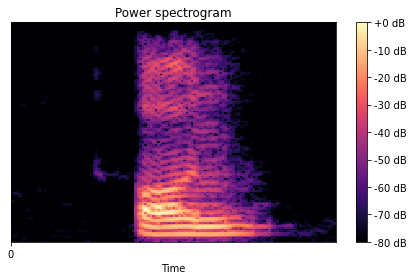

In [27]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(batch_xs.reshape(130,126), ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()